# GAT and ResidualGAT Visualization

by **Jahnvi Patel** (jpate201@illinois.edu) 

CS598: Deep Learning for Healthcare

In this reproducibility study, we aim to assess the performance of the Graph Attention Network (GAT) model and the ResidualGAT model on three citation networks: Cora, Citeseer, and Pubmed. To accomplish this, we will utilize the PyTorch library for both training and evaluation processes. The reproducibility study is based on the original paper *Graph Attention Networks* by Veličković et al. (2018).

The study will contribute to potential enhancements in GAT and provide guidance for future research in graph-based machine learning methodologies. The reproducibility paper outlines the steps taken to preprocess the datasets and implement the GAT and ResidualGAT models for training and evaluation. In this Jupyter notebook, we will gather performance metrics to visualize the data for better interpretation.

First, we need to import the required libraries.

In [219]:
import torch
import copy
import matplotlib.pyplot as plt
from datasets import load_datasets
from models import GAT, ResidualGAT
from train_test_utils import train, test, calculate_f1_score, evaluate_metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import os
import numpy as np

# Methodology 

The datasets are preprocessed and split into training, validation, and testing sets. The GAT and ResidualGAT models are trained on the training set using the Adam optimization algorithm, and model performance is validated on the validation set using metrics such as accuracy, precision, recall, and F1-score. The models are tested on the testing set, and their performance metrics are reported. A sensitivity analysis is conducted to evaluate the impact of hyperparameters and model configurations on ResidualGAT performance. The study also includes data visualization and exploration of the structure and relationships within the citation networks. 

# GAT and ResidualGAT on *Cora* 

Here we will train and evaluate the GAT and ResidualGAT models on the *Cora* dataset. 


Training and Evaluating Cora on GAT
------------------------------------
F1 score before training: 0.0745
Epoch: 010, Train: 0.8357, Val: 0.6240
Epoch: 020, Train: 0.9071, Val: 0.6700
Epoch: 030, Train: 0.9357, Val: 0.7440
Epoch: 040, Train: 0.9643, Val: 0.8020
Epoch: 050, Train: 0.9786, Val: 0.7900
Epoch: 060, Train: 0.9786, Val: 0.8040
Epoch: 070, Train: 0.9714, Val: 0.8000
Epoch: 080, Train: 0.9714, Val: 0.8080
Epoch: 090, Train: 0.9857, Val: 0.8120
Epoch: 100, Train: 0.9929, Val: 0.8100
Epoch: 110, Train: 0.9929, Val: 0.8160
Epoch: 120, Train: 0.9857, Val: 0.8100
Epoch: 130, Train: 0.9857, Val: 0.8080
Epoch: 140, Train: 0.9857, Val: 0.8060
Epoch: 150, Train: 0.9857, Val: 0.8040
Epoch: 160, Train: 0.9929, Val: 0.8160
Epoch: 170, Train: 0.9857, Val: 0.8060
Epoch: 180, Train: 0.9929, Val: 0.8160
Epoch: 190, Train: 0.9857, Val: 0.8040
Epoch: 200, Train: 0.9929, Val: 0.8040
Train metrics:
  Accuracy: 0.9928571581840515
  Precision: 0.9931972789115646
  Recall: 0.9928571428571429
  F1 s

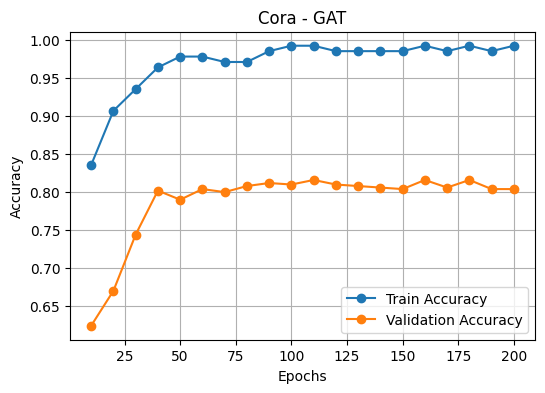

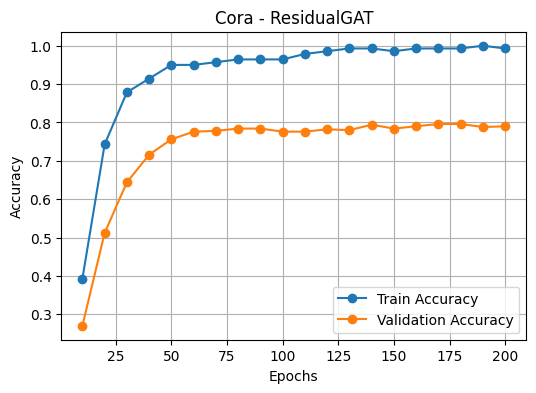

In [217]:
def compute_metrics(model, data, mask):
    model.eval()
    with torch.no_grad():
        # Create a custom data object with the required attributes
        custom_data = type('', (), {})()
        custom_data.x = data.x.to(device)
        custom_data.edge_index = data.edge_index.to(device)
        
        logits = model(custom_data)
        pred = logits[mask].max(1)[1].cpu()
        true_labels = data.y[mask].cpu()

    accuracy = accuracy_score(true_labels, pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred, average='weighted')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

def train_and_evaluate(model_type, data, device):
    
    # Create the GAT or ResidualGAT model based on the specified model_type
    if model_type == "GAT":
        model = GAT(data=data, heads_layer1=8, heads_layer2=1, dropout=0.6, dropout_alphas=0.6).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
    elif model_type == "ResidualGAT":
        model = ResidualGAT(data=data, heads_layer1=16, heads_layer2=8, dropout=0.7, dropout_alphas=0.7).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    else:
        raise ValueError("Invalid model type. Choose either 'GAT' or 'ResidualGAT'.")

    data = data.to(device)
    
    train_acc = []
    val_acc = []

    # Calculate and print the F1 score before training
    f1_before = calculate_f1_score(model, data, data.test_mask)
    print("F1 score before training: {:.4f}".format(f1_before))

    best_val_acc = 0
    patience = 10
    counter = 0
    best_model = None

    # Train the model for 200 epochs or until early stopping is triggered
    for epoch in range(1, 200 + 1):
        train(model, data, optimizer)
        if epoch % 10 == 0:
            acc_train, acc_val = test(model, data)
            train_acc.append(acc_train)
            val_acc.append(acc_val)
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}'
            print(log.format(epoch, acc_train, acc_val))
            
            # Update the best model and early stopping counter
            if acc_val > best_val_acc:
                best_val_acc = acc_val
                counter = 0
                best_model = copy.deepcopy(model)
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping.")
                    break

    model = best_model
    
    evaluate_metrics(model, data)

    return model, train_acc, val_acc

# Load datasets and set device
data_cora, data_citeseer, data_pubmed = load_datasets()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Train and evaluate the GAT and ResidualGAT models for Cora, Citeseer, and Pubmed datasets
model_types = ["GAT","ResidualGAT"]
datasets = {"Cora": data_cora}
results = {}

for model_type in model_types:
    for dataset_name, dataset in datasets.items():
        print(f"\nTraining and Evaluating {dataset_name} on {model_type}")
        print("------------------------------------")
        model, train_acc, val_acc = train_and_evaluate(model_type, dataset, device)
        results[f"{dataset_name}_{model_type}"] = {"model": model, "train_acc": train_acc, "val_acc": val_acc}

# Create the output folder if it doesn't exist
if not os.path.exists('data_output'):
    os.makedirs('data_output')

for i, dataset_name in enumerate(datasets):
    for j, model_type in enumerate(model_types):
        train_acc = results[f"{dataset_name}_{model_type}"]["train_acc"]
        val_acc = results[f"{dataset_name}_{model_type}"]["val_acc"]
        epochs = range(10, len(train_acc) * 10 + 1, 10)

        fig, ax = plt.subplots(figsize=(6, 4))

        ax.plot(epochs, train_acc, label='Train Accuracy', marker='o')
        ax.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
        ax.set_title(f"{dataset_name} - {model_type}")
        ax.legend()
        ax.grid()

        # Add epoch and accuracy labels to each plot
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')

        # Save each plot as an image in the output folder
        output_file = f"data_output/{dataset_name}_{model_type}.png"
        fig.savefig(output_file)
        print(f"Saved plot to {output_file}")

plt.show()
plt.close()

# GAT and ResidualGAT on *CiteSeer*

Here we will train and evaluate the GAT and ResidualGAt models on the *CiteSeer* dataset. 


Training and Evaluating CiteSeer on GAT
------------------------------------
F1 score before training: 0.1421
Epoch: 010, Train: 0.6250, Val: 0.3380
Epoch: 020, Train: 0.9167, Val: 0.6760
Epoch: 030, Train: 0.9083, Val: 0.6840
Epoch: 040, Train: 0.9417, Val: 0.7060
Epoch: 050, Train: 0.9250, Val: 0.7160
Epoch: 060, Train: 0.9250, Val: 0.7020
Epoch: 070, Train: 0.9333, Val: 0.7040
Epoch: 080, Train: 0.9333, Val: 0.7120
Epoch: 090, Train: 0.9500, Val: 0.7040
Epoch: 100, Train: 0.9333, Val: 0.7060
Epoch: 110, Train: 0.9333, Val: 0.6900
Epoch: 120, Train: 0.9417, Val: 0.7120
Epoch: 130, Train: 0.9500, Val: 0.7060
Epoch: 140, Train: 0.9667, Val: 0.7100
Epoch: 150, Train: 0.9917, Val: 0.7060
Early stopping.
Train metrics:
  Accuracy: 0.925000011920929
  Precision: 0.9304918257435421
  Recall: 0.9250000000000002
  F1 score: 0.9234706665364635

Validation metrics:
  Accuracy: 0.7160000205039978
  Precision: 0.689498826537761
  Recall: 0.6725733412845702
  F1 score: 0.6738904003223736

Trainin

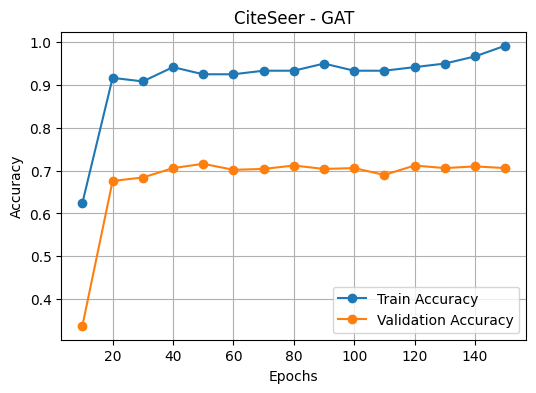

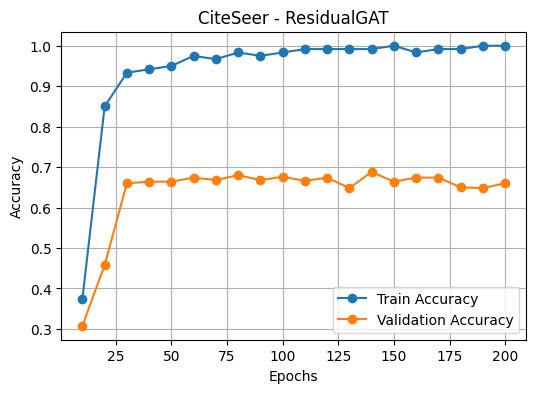

In [209]:
def compute_metrics(model, data, mask):
    model.eval()
    with torch.no_grad():
        # Create a custom data object with the required attributes
        custom_data = type('', (), {})()
        custom_data.x = data.x.to(device)
        custom_data.edge_index = data.edge_index.to(device)
        
        logits = model(custom_data)
        pred = logits[mask].max(1)[1].cpu()
        true_labels = data.y[mask].cpu()

    accuracy = accuracy_score(true_labels, pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred, average='weighted')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

def train_and_evaluate(model_type, data, device):
    
    # Create the GAT or ResidualGAT model based on the specified model_type
    if model_type == "GAT":
        model = GAT(data=data, heads_layer1=8, heads_layer2=1, dropout=0.6, dropout_alphas=0.6).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
    elif model_type == "ResidualGAT":
        model = ResidualGAT(data=data, heads_layer1=16, heads_layer2=1, dropout=0.7, dropout_alphas=0.7).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
    else:
        raise ValueError("Invalid model type. Choose either 'GAT' or 'ResidualGAT'.")

    data = data.to(device)
    
    train_acc = []
    val_acc = []

    # Calculate and print the F1 score before training
    f1_before = calculate_f1_score(model, data, data.test_mask)
    print("F1 score before training: {:.4f}".format(f1_before))

    best_val_acc = 0
    patience = 10
    counter = 0
    best_model = None

    # Train the model for 200 epochs or until early stopping is triggered
    for epoch in range(1, 200 + 1):
        train(model, data, optimizer)
        if epoch % 10 == 0:
            acc_train, acc_val = test(model, data)
            train_acc.append(acc_train)
            val_acc.append(acc_val)
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}'
            print(log.format(epoch, acc_train, acc_val))
            
            # Update the best model and early stopping counter
            if acc_val > best_val_acc:
                best_val_acc = acc_val
                counter = 0
                best_model = copy.deepcopy(model)
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping.")
                    break

    model = best_model
    
    evaluate_metrics(model, data)

    return model, train_acc, val_acc

# Load datasets and set device
data_cora, data_citeseer, data_pubmed = load_datasets()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and evaluate the GAT and ResidualGAT models for Cora, Citeseer, and Pubmed datasets
model_types = ["GAT","ResidualGAT"]
datasets = {"CiteSeer": data_citeseer}
results = {}

for model_type in model_types:
    for dataset_name, dataset in datasets.items():
        print(f"\nTraining and Evaluating {dataset_name} on {model_type}")
        print("------------------------------------")
        model, train_acc, val_acc = train_and_evaluate(model_type, dataset, device)
        results[f"{dataset_name}_{model_type}"] = {"model": model, "train_acc": train_acc, "val_acc": val_acc}
        
# Create the output folder if it doesn't exist
if not os.path.exists('data_output'):
    os.makedirs('data_output')

for i, dataset_name in enumerate(datasets):
    for j, model_type in enumerate(model_types):
        train_acc = results[f"{dataset_name}_{model_type}"]["train_acc"]
        val_acc = results[f"{dataset_name}_{model_type}"]["val_acc"]
        epochs = range(10, len(train_acc) * 10 + 1, 10)

        fig, ax = plt.subplots(figsize=(6, 4))

        ax.plot(epochs, train_acc, label='Train Accuracy', marker='o')
        ax.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
        ax.set_title(f"{dataset_name} - {model_type}")
        ax.legend()
        ax.grid()

        # Add epoch and accuracy labels to each plot
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')

        # Save each plot as an image in the output folder
        output_file = f"data_output/{dataset_name}_{model_type}.png"
        fig.savefig(output_file)
        print(f"Saved plot to {output_file}")

plt.show()
plt.close()

# GAT and ResidualGAT on *PubMed* 

Here we will train and evaluate the GAT and ResidualGAt models on the *PubMed* dataset. 


Training and Evaluating PubMed on GAT
------------------------------------
F1 score before training: 0.2502
Epoch: 010, Train: 0.8167, Val: 0.7180
Epoch: 020, Train: 0.8667, Val: 0.7300
Epoch: 030, Train: 0.9167, Val: 0.7300
Epoch: 040, Train: 0.9167, Val: 0.7420
Epoch: 050, Train: 0.9333, Val: 0.7560
Epoch: 060, Train: 0.9333, Val: 0.7800
Epoch: 070, Train: 0.9333, Val: 0.7780
Epoch: 080, Train: 0.9500, Val: 0.7740
Epoch: 090, Train: 0.9500, Val: 0.7960
Epoch: 100, Train: 0.9833, Val: 0.7840
Epoch: 110, Train: 0.9500, Val: 0.7940
Epoch: 120, Train: 0.9833, Val: 0.7980
Epoch: 130, Train: 0.9833, Val: 0.7880
Epoch: 140, Train: 0.9833, Val: 0.7980
Epoch: 150, Train: 0.9833, Val: 0.7920
Epoch: 160, Train: 0.9833, Val: 0.8000
Epoch: 170, Train: 0.9833, Val: 0.7960
Epoch: 180, Train: 1.0000, Val: 0.7900
Epoch: 190, Train: 1.0000, Val: 0.7840
Epoch: 200, Train: 1.0000, Val: 0.7920
Train metrics:
  Accuracy: 0.9833333492279053
  Precision: 0.9841269841269842
  Recall: 0.9833333333333334
  F1

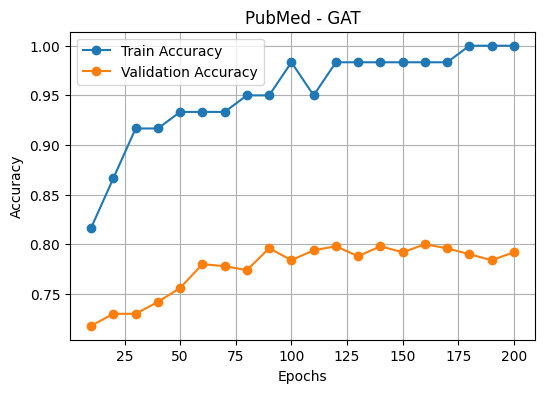

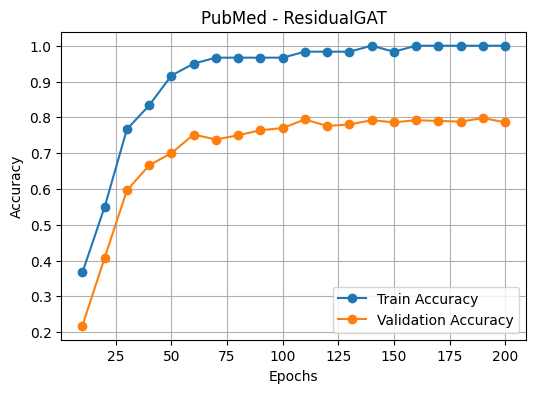

In [215]:
def compute_metrics(model, data, mask):
    model.eval()
    with torch.no_grad():
        # Create a custom data object with the required attributes
        custom_data = type('', (), {})()
        custom_data.x = data.x.to(device)
        custom_data.edge_index = data.edge_index.to(device)
        
        logits = model(custom_data)
        pred = logits[mask].max(1)[1].cpu()
        true_labels = data.y[mask].cpu()

    accuracy = accuracy_score(true_labels, pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred, average='weighted')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

def train_and_evaluate(model_type, data, device):
    
    # Create the GAT or ResidualGAT model based on the specified model_type
    if model_type == "GAT":
        model = GAT(data=data, heads_layer1=8, heads_layer2=1, dropout=0.6, dropout_alphas=0.6).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
    elif model_type == "ResidualGAT":
        model = ResidualGAT(data=data, heads_layer1=6, heads_layer2=6, dropout=0.8, dropout_alphas=0.2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=6e-4)
    else:
        raise ValueError("Invalid model type. Choose either 'GAT' or 'ResidualGAT'.")

    data = data.to(device)
    
    train_acc = []
    val_acc = []

    # Calculate and print the F1 score before training
    f1_before = calculate_f1_score(model, data, data.test_mask)
    print("F1 score before training: {:.4f}".format(f1_before))

    best_val_acc = 0
    patience = 10
    counter = 0
    best_model = None

    # Train the model for 200 epochs or until early stopping is triggered
    for epoch in range(1, 200 + 1):
        train(model, data, optimizer)
        if epoch % 10 == 0:
            acc_train, acc_val = test(model, data)
            train_acc.append(acc_train)
            val_acc.append(acc_val)
            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}'
            print(log.format(epoch, acc_train, acc_val))
            
            # Update the best model and early stopping counter
            if acc_val > best_val_acc:
                best_val_acc = acc_val
                counter = 0
                best_model = copy.deepcopy(model)
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping.")
                    break

    model = best_model
    
    evaluate_metrics(model, data)

    return model, train_acc, val_acc

# Load datasets and set device
data_cora, data_citeseer, data_pubmed = load_datasets()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train and evaluate the GAT and ResidualGAT models for Cora, Citeseer, and Pubmed datasets
model_types = ["GAT","ResidualGAT"]
datasets = {"PubMed": data_pubmed}
results = {}

for model_type in model_types:
    for dataset_name, dataset in datasets.items():
        print(f"\nTraining and Evaluating {dataset_name} on {model_type}")
        print("------------------------------------")
        model, train_acc, val_acc = train_and_evaluate(model_type, dataset, device)
        results[f"{dataset_name}_{model_type}"] = {"model": model, "train_acc": train_acc, "val_acc": val_acc}
        
# Create the output folder if it doesn't exist
if not os.path.exists('data_output'):
    os.makedirs('data_output')

for i, dataset_name in enumerate(datasets):
    for j, model_type in enumerate(model_types):
        train_acc = results[f"{dataset_name}_{model_type}"]["train_acc"]
        val_acc = results[f"{dataset_name}_{model_type}"]["val_acc"]
        epochs = range(10, len(train_acc) * 10 + 1, 10)

        fig, ax = plt.subplots(figsize=(6, 4))

        ax.plot(epochs, train_acc, label='Train Accuracy', marker='o')
        ax.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
        ax.set_title(f"{dataset_name} - {model_type}")
        ax.legend()
        ax.grid()

        # Add epoch and accuracy labels to each plot
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Accuracy')

        # Save each plot as an image in the output folder
        output_file = f"data_output/{dataset_name}_{model_type}.png"
        fig.savefig(output_file)
        print(f"Saved plot to {output_file}")

plt.show()
plt.close()

# Results

These results are from training and evaluating various citation network datasets (*Cora, CiteSeer, PubMed*) on GAT and ResidualGAT model. 

The results show the performance of each model in terms of F1 score at different epochs of training. Additionally, the accuracy, precision, recall, and F1 score for both the training and validation sets are reported after training is completed.

In general, the results show that the Residual GAT model outperforms the standard GAT model on all datasets. The models achieve high accuracy, precision, recall, and F1 score on the training set, and the validation sets have relatively good performance as well, although not as high as the training sets.

# References

Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2018). Graph attention networks. arXiv preprint arXiv:1710.10903. Link: https://arxiv.org/abs/1710.10903